In [36]:
##### Code catalog
##### 12/09/2023 - Organize from One-node-final folder. Github has another final version, compare and update later
#####
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
from itertools import count
from utils import *
from networkutils import *
import os

## Configurations

In [37]:
network_name = 'reddit'
# network_name = 'karate'
is_reddit = network_name == 'reddit'

np.set_printoptions(precision=3)

# Game Parameters
Game_rounds = 2  # Rounds + 1 - use for printing data
memory = 0  # Game parameter - for zero-sum, the memory is always 0
Experiment = 1

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)

## Creating Network
### 1. Import Network

In [38]:
G, s, n, network_anl = import_network(network_name)
nxG = nx.from_numpy_array(G)

### 2. Network Visualization

<Figure size 2000x2000 with 0 Axes>

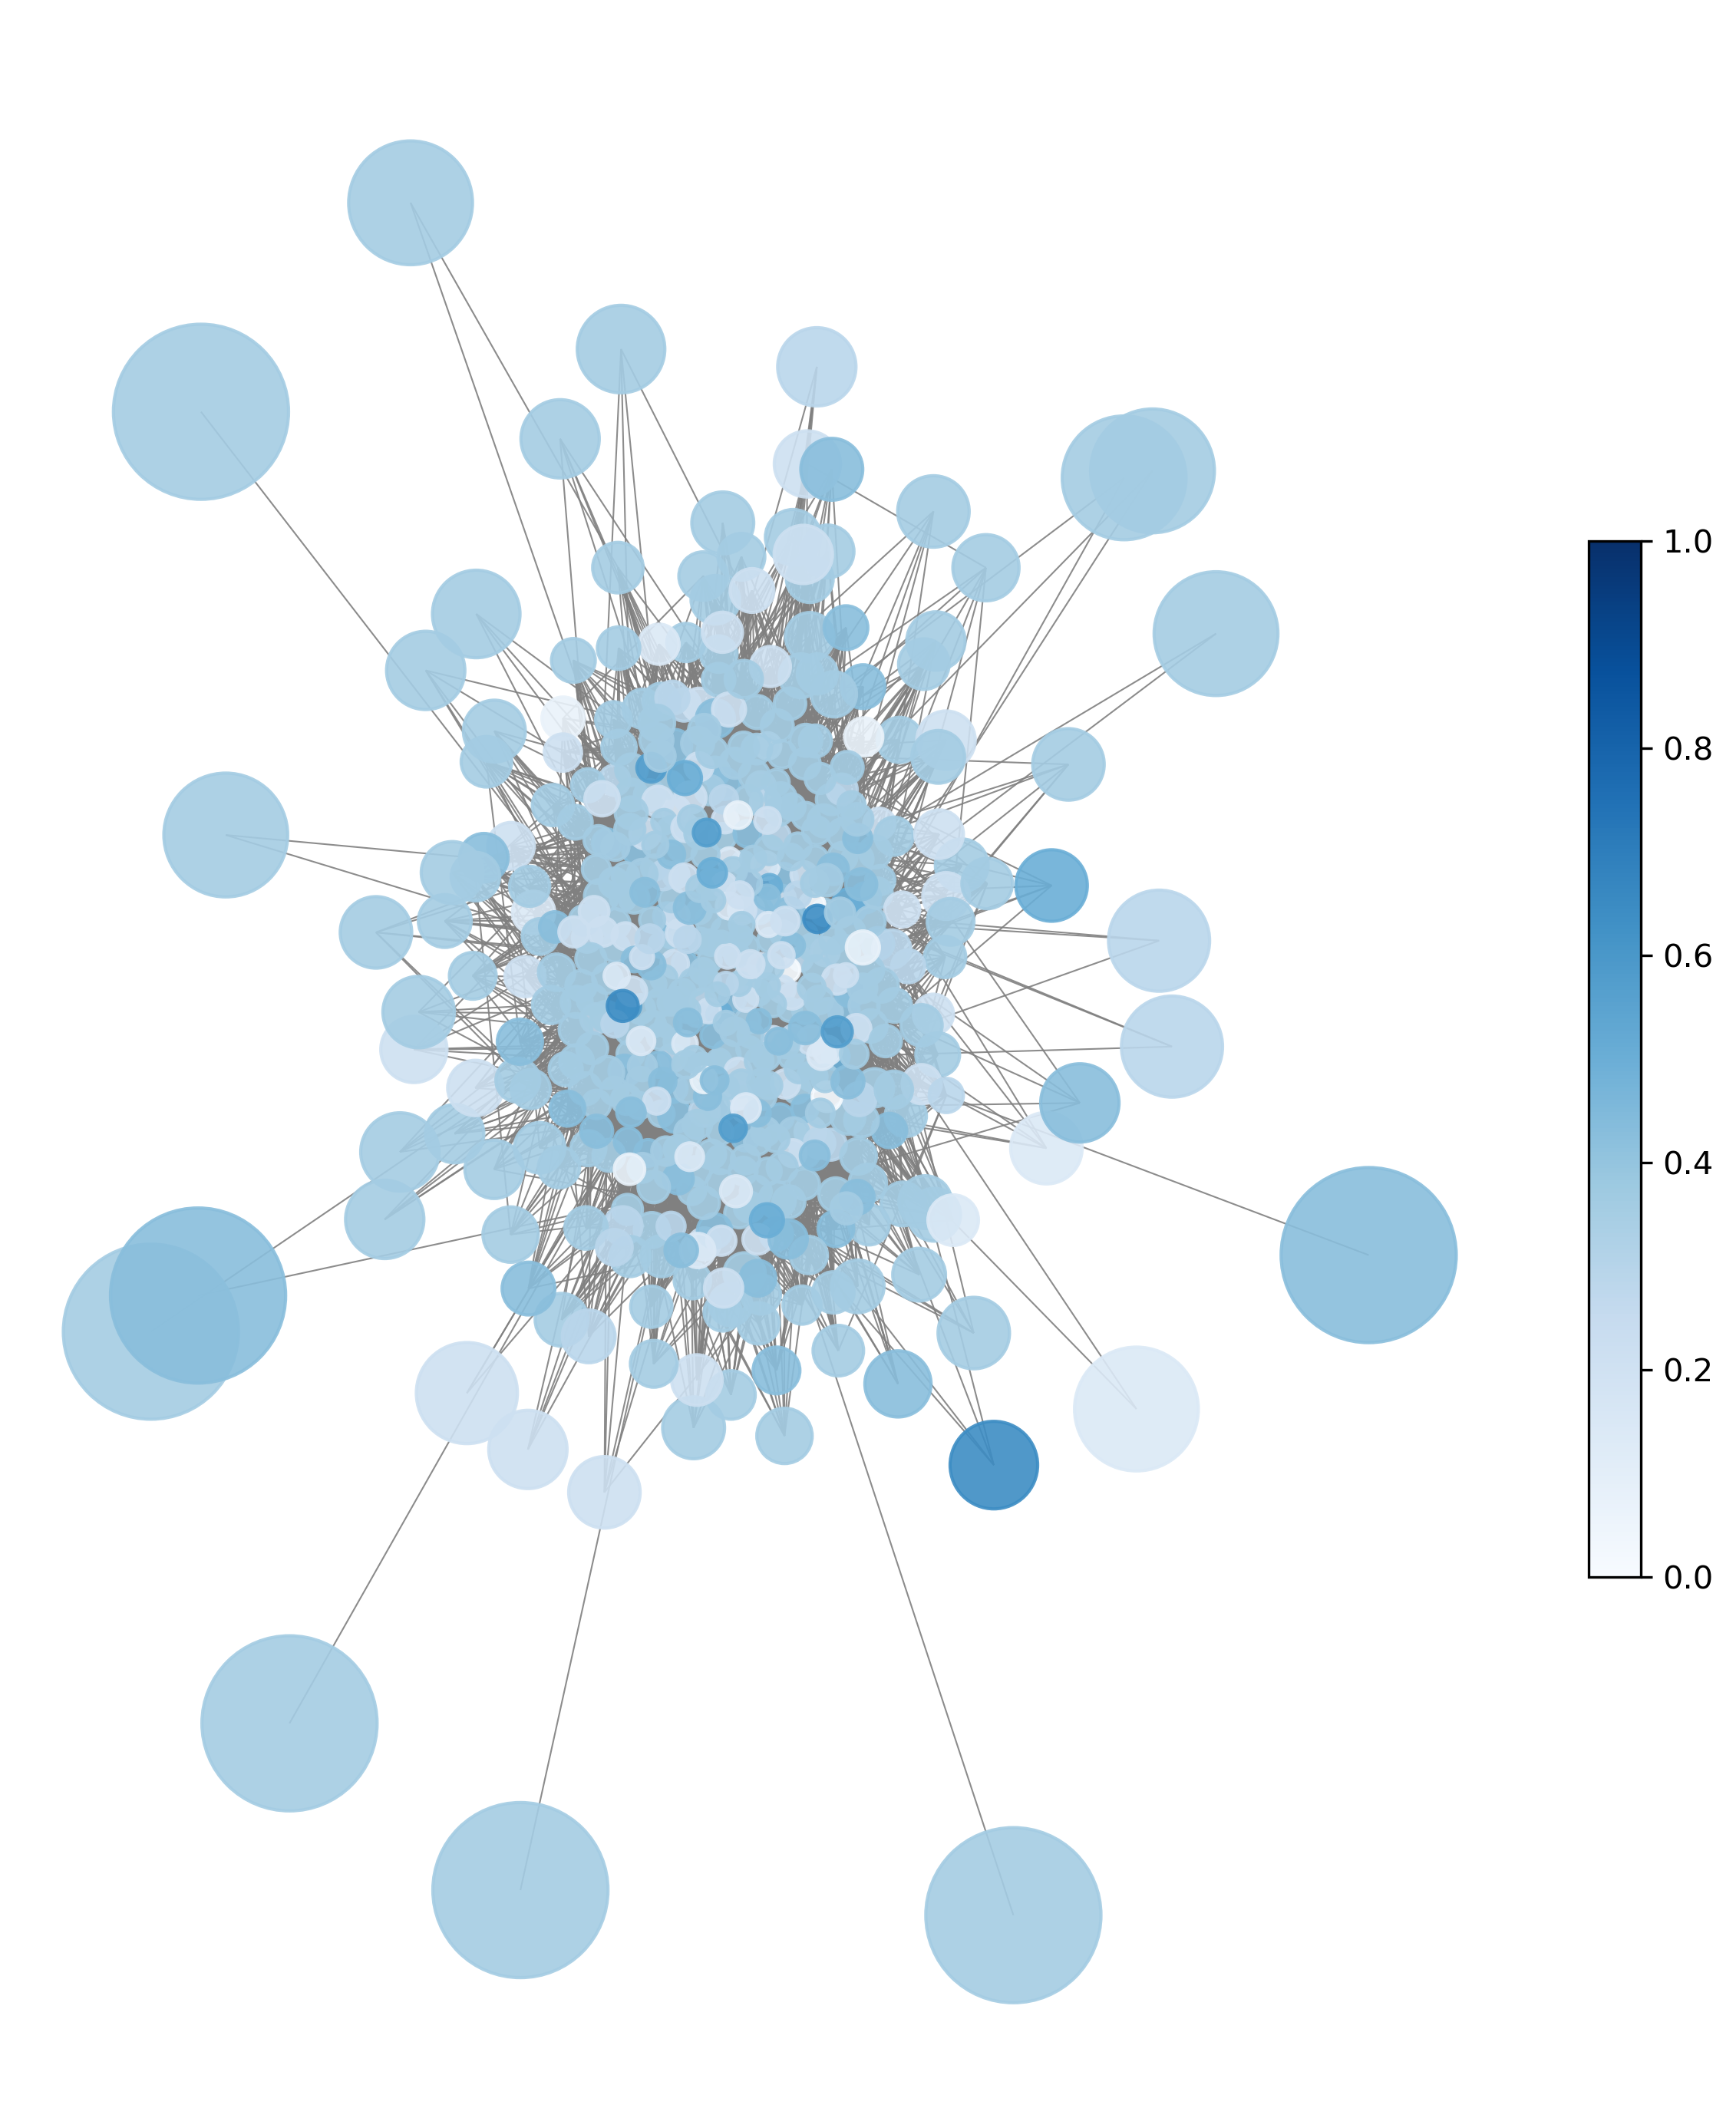

In [39]:
############################ Make Innate Opinion ################################

# Calculate Key Values & Visualization #######################################3
# the Laplacian matrix
L = scipy.sparse.csgraph.laplacian(G, normed=False)
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)  Adjacency Matrix
# call the function to calculate the number of edges
m = num_edges(L, n)
columnsum_ij = np.sum(A, axis=0)
plt.figure(figsize=(20, 20))


node_edges = get_node_edges(G, n)
min_equi = []
max_equi = []

# create color map
color_map = []
for node in nxG:
    if node in min_equi:
        color_map.append('orange')
    elif node in max_equi:
        color_map.append('Red')
    else:
        # color_map.append('#1f77b4')
        color_map.append('grey')

# create node color map value
# convert opinion array into data frame
s_use = s.flatten().tolist()
new_s = [i * 30 for i in s_use]
# create a data frame with index at column 1, opinion at column 2
df = pd.DataFrame(new_s, columns=['Opinion'])

# create node sizes
node_sizes = []
for i in node_edges:
    node_size = 1/i*3000
    node_sizes.append(node_size)

# visualize the network in high resolution
plt.figure(figsize=(8, 9), dpi=300)  # Set the DPI for high resolution
# draw subgraph for highlights
# set a seed so the network will not give random layout
my_pos = nx.spring_layout(nxG, k=0.3, seed=2)
nx.draw(nxG, pos=my_pos, with_labels=False, node_color=df['Opinion'].astype(int),
        cmap=plt.cm.Blues, node_size=node_sizes, edge_color='grey', width=0.5,
        font_color='black', font_size=12, font_weight='bold', alpha=0.9)
# nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')

sm = plt.cm.ScalarMappable(
    cmap=plt.cm.Blues,
    norm=plt.Normalize(vmin=0, vmax=1)
)

# visualize the network in high resolution
cbar = plt.colorbar(sm, shrink=0.5, ax=plt.gca())

## 3. Network Property Visualization

Text(0, 0.5, 'Number of Agents')

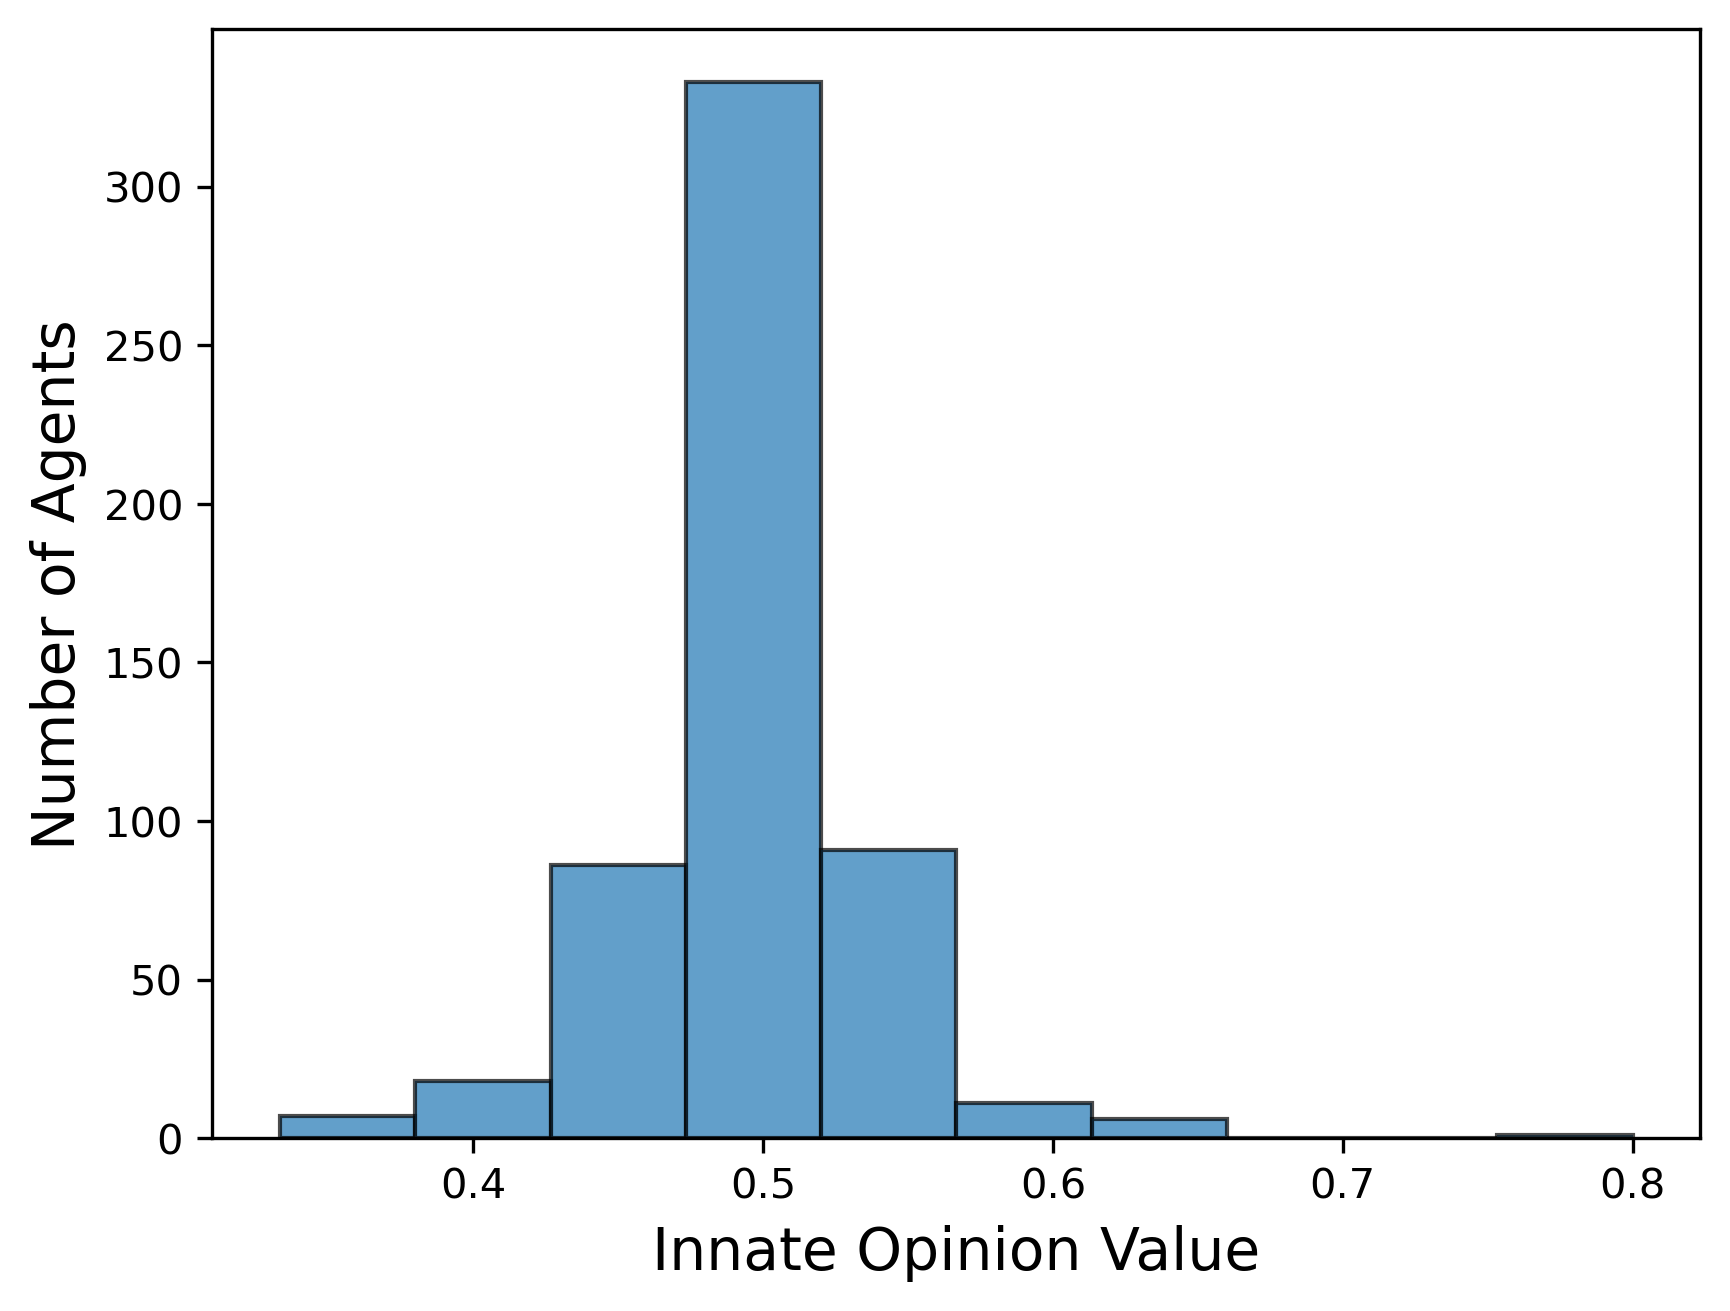

In [40]:
plt.figure(dpi=300)
# Create a histogram
plt.hist(s, bins=10, edgecolor='black', alpha=0.7)
# new_list = range(0, 3)
# plt.ylim(0,8)
# plt.yticks(range(0, 10, 2))
# Add labels and title
plt.xlabel('Innate Opinion Value', fontsize=14)
plt.ylabel('Number of Agents', fontsize=14)
# Save the figure as a high-quality PNG image
# plt.savefig(f'results/${network_type}_opinion_histograms.png', dpi=800)  # Adjust dpi for higher quality

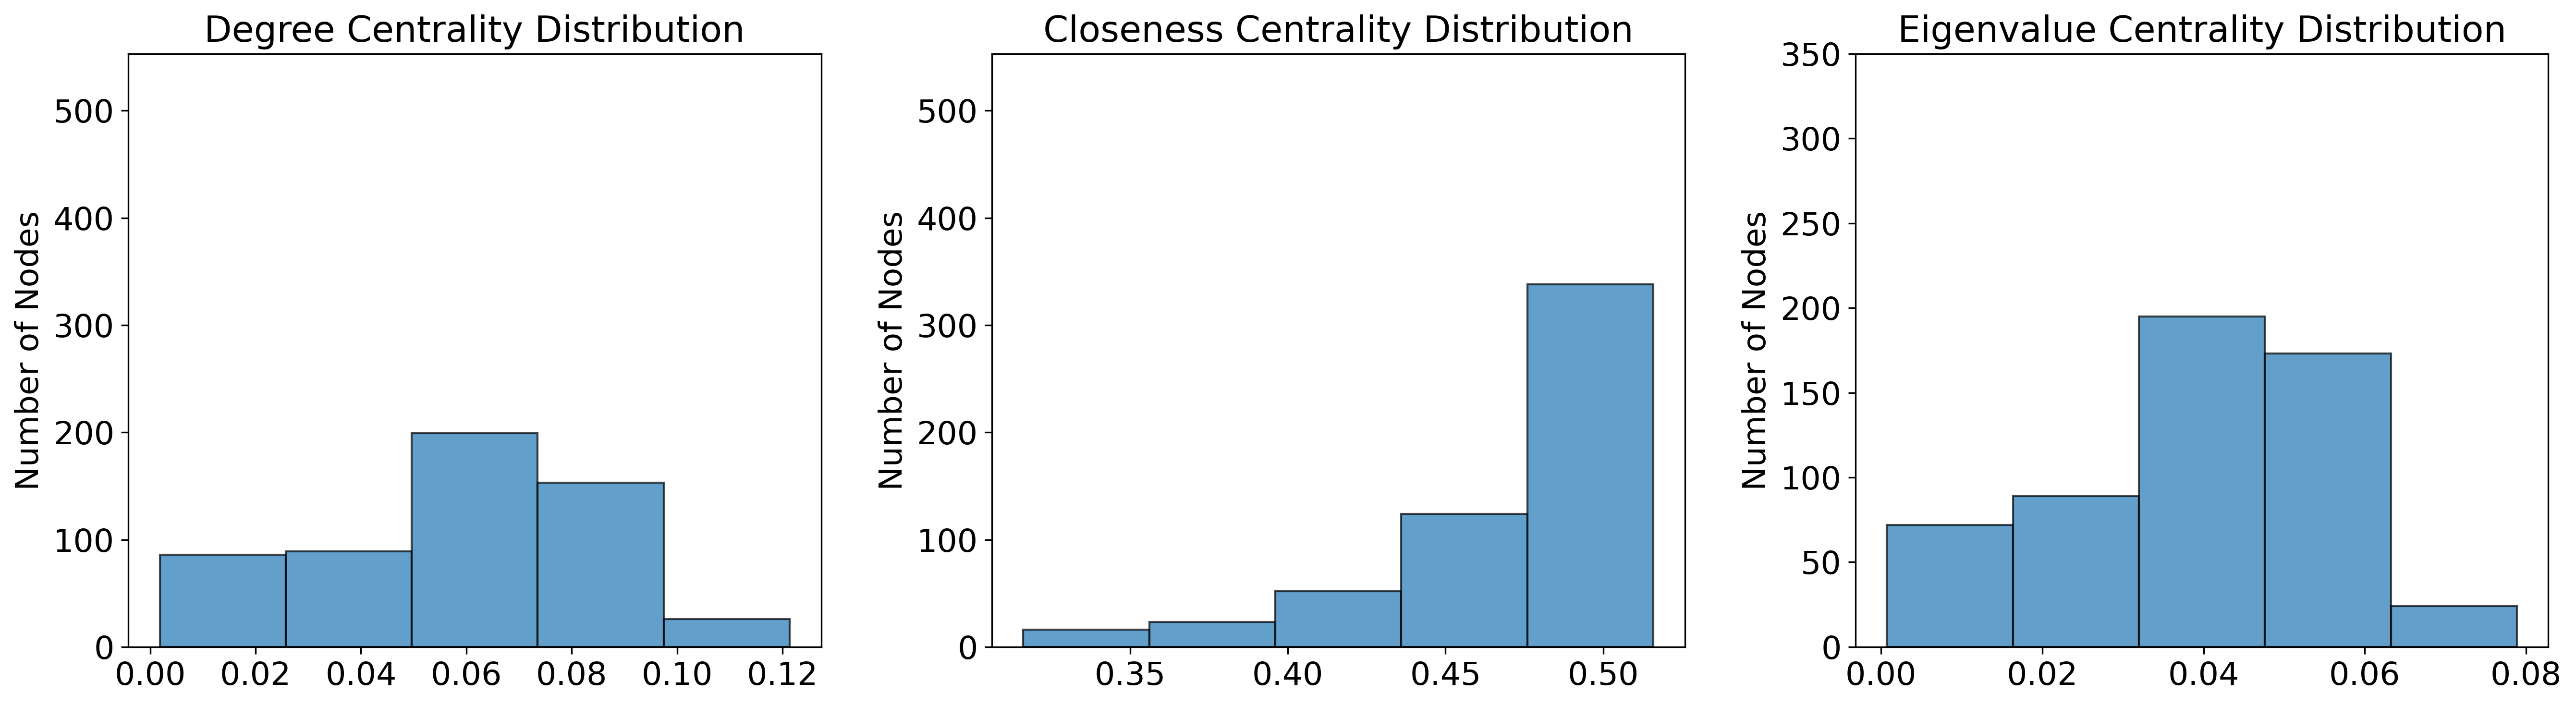

In [41]:
degree_df = calculate_centrality_and_convert_to_df(nxG, nx.degree_centrality)
closeness_df = calculate_centrality_and_convert_to_df(nxG, nx.closeness_centrality)
eigenvector_df = calculate_centrality_and_convert_to_df(nxG, nx.eigenvector_centrality)

ylim = max(len(degree_df), len(closeness_df), len(eigenvector_df))

# Plot histograms of centrality measures in a horizontal layout
# Set DPI to 300 for higher resolution
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

plot_centrality_histogram(axs[0], degree_df, 'Degree Centrality Distribution', ylim, False)
plot_centrality_histogram(axs[1], closeness_df, 'Closeness Centrality Distribution', ylim, False)
plot_centrality_histogram(axs[2], eigenvector_df, 'Eigenvalue Centrality Distribution', ylim, is_reddit)

plt.tight_layout()
# Save the figure as a high-quality PNG image
# Adjust dpi for higher quality
plt.savefig(f'results/{network_name}_centrality_histograms.png', dpi=800)

plt.show()

In [42]:
# Analyze node feature
nod_ind = 29  # index of node - start with 0

network_anl(s, n, G, nod_ind)
# print(s)
print("__Minimum Eigen_value Centrality__")
print(np.min(eigenvector_df))
print("__Maximum opinion_")
print(min(s))

29 opinion: [0.5]
29 neighbors: (array([ 11, 107, 125, 150, 189, 211, 284, 311, 319, 325, 350, 379, 406,
       412, 485, 486]),)
Opinion rank of this agent is: [155]
_______________Degree Centrality___________________
rank of this agent is : [90]
0.028985507246376812
                           
_______________Closeness Rank________________________
rank of this agent is : [90]
0.43567482241515393
                           
_______________Page Rank_____________________________
rank of this agent is : [93]
0.02108802985242771
                           
Agent's opinion gap to mean opinion is ranked as: [155]
__Minimum Eigen_value Centrality__
0.0007349912233008693
__Maximum opinion_
[0.333]


### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [43]:
# Calculate network polarization
calculate_polarization(s, n, A, L)

Innate_polarization:	0.9625703647920463
Equi_polarization:	0.005278437803904967
Difference:		-0.9572919269881413


### Testing players' behavior

In [44]:
def random_play(s, n):  # player randomly choose an agent and randomly change the agent
    op = copy.copy(s)

    v = random.randint(0, n-1)  # randomly select an agent index
    # print(v)
    new_op = random.randint(0, 1)  # randomly select an opinion between 0 and 1
    # new_op = random.uniform(0, 1)
    print(new_op)

    # Store old opinion
    old_opinion = op[v, 0]

    # update the opinion
    op[v, 0] = new_op
    # print('Only 1 opinion changed')
    # print(op)
    print(f"    Agent{str(v)}'s opinion {str(old_opinion)} changed to {str(new_op)}")
    por = obj_polarization(A, L, op, n)

    # restore op op array to innate opinion
    op[v] = old_opinion
    print(f"Network reaches equilibrium Polarization: {str(por)}")
    # print('Should be restored')
    # print(op)
    return (v, new_op, por)

In [45]:
def maximizer_fir_play(s, n, min_touched):
    """
    maximizer first-time play, greedy algorithm
    """
    op = copy.copy(s)

    print('Maximizer Play')

    # The best choice among all opinions and vertexs, function is in "pure_strategy_selection.ipynb"
    max_champion = choose_max_vertex(op, n, min_touched)
    # find agent v1, and max_opinion that can maxmize the equi_polarization(max_pol)
    (v1, max_opinion, innate_obj, max_pol) = max_champion

    if v1 == None:   # if maximizer cannot find one
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
        # print('v1', 'changed_opinion', 'innate_obj', 'obj')
        # print(max_champion)

        # Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]
        # change the agent's opinion with best action(agent v1, max_op)
        op[v1, 0] = max_opinion
        # check if agent's opinion is changed or not
        print(f"    Agent{str(v1)}'s opinion {str(old_opinion_max)} changed to {str(max_opinion)}")
        print(f"Network reaches equilibrium Polarization: {str(max_pol)}")

    return (v1, max_opinion, max_pol)

In [46]:
def minimizer_fir_play(s, n, max_touched):
    """
    minimizer first-time play, greedy algorithm
    """

    op = copy.copy(s)
    print('_______________________')
    print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)

    min_champion = choose_min_vertex(op, n, max_touched)
    (v2, min_opinion, innat_equi_por, min_pol) = min_champion

   # Store innate_op of the min_selected vertex
    old_opinion_min = op[v2, 0]

    if v2 == None:
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")

        # change the agent's opinion
        # -------------------------------------------------> store minimize strategy
        op[v2, 0] = min_opinion

        print(f"    Agent{str(v2)}'s opinion {str(old_opinion_min)} changed to {str(min_opinion)}")

        print(f"Network reaches equilibrium Polarization: {str(min_pol)}")
        # print('2 opinion changed')
        # print(op)

    return (v2, min_opinion, min_pol)

In [47]:
# max_touched = []
# min_touched = []
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
# print(v2, min_opinion, min_pol)

In [48]:
## Testing above functions
# min_touched=[]
# max_touched=[]
# # Game start from maximizer random play
# print('Maximizer random selection')
# (v1, max_opinion, max_pol) = random_play(s,n)
# max_touched.append(v1)
# # print('v1, max_opinion, max_pol')
# # print(v1, max_opinion, max_pol)
# # store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history


# # Game start from minimizer random play
# print('Minimizer random selection')
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
# min_touched.append(v2)

In [49]:
# Row are Column are depended on min and max's choice: agent v and opinion
def row_index(v2, min_opinion):
    row = 11*v2 + min_opinion*10
    return int(row)


def column_index(v1, max_opinion):
    column = 2*v1 + max_opinion
    return int(column)  # the python data frame index

### Mixed Strategy Payoff


In [50]:
def make_payoff_row(op1, v2):
    payoff_row = np.zeros(2*n)

    # print('one opinion changed -min')
    # print(op1)
    for column in range(2*n):
        # print(column)
        v1 = int(column/2)  # i.e., column 11 is agent 5, opinion 1
        max_opinion = column % 2
        # print(v1, max_opinion)
        # update the maximizer's change to the opinion array that has changed by minimizer(op1)
        op2 = copy.copy(op1)
        # temp = op1[v1]
        op2[v1, 0] = max_opinion

        # calculate the polarization with both max and min's action
        payoff_row[column] = obj_polarization(A, L, op2, n)
        # op1[v1,0] = temp # restore
        # print(op2,payoff_row[column])

    # when v1 == v2, the polarization should be negative for max, infinite for min.
    ####################### ZERO SUM when v1==v2, the polarization is innate polarization########################
    j_1 = 2*v2 + 0
    j_2 = 2*v2 + 1
    O_P = obj_polarization(A, L, s, n)
    payoff_row[j_1] = O_P
    payoff_row[j_2] = O_P

    return payoff_row

### Minimizer Mixed Strategy

In [51]:
def mixed_min_polarization(s, v2, weight_op, fla_max_fre):
    """
    Calculate polarization of minimizer's Mixed Strategy
    """

    op1 = copy.copy(s)  # make a copy of the innate opinion array
    op1[v2, 0] = weight_op  # then only updated by minimizer's current change
    # print('Min update')
    # print(v2, weight_op)

    # calculate the polarization with both min(did here) and max's action(in make_payoff_row)
    # the vector list out 2*n payoffs after min's action combine with 2*n possible max's actions
    payoff_row = make_payoff_row(op1, v2)
    # print(payoff_row)

    # Replace the the column_index of agent v2 with 100 for min - NO NEED TO REPLACE NOW

    # print('Min Payoff Row')
    # print(payoff_row)

    # calculate fictitious payoff - equi_min
    # fla_max_fre recorded the frequency of each maximizer's action, frequency sum = 1
    payoff_cal = payoff_row * fla_max_fre
    # payoff (2*n array) * maximizer_action_frequency (2*n array)

    # add up all, calculate average/expected payoff
    mixed_pol = np.sum(payoff_cal)

    # print('min_mixed_polarization')
    # print(mixed_pol)
    # Replace the the column_index of agent v2 with 100 for min

    return (mixed_pol, payoff_row)

In [52]:
def derivate_s(op, n, v2):
    # op - opinion array that updated by maximizer
    c = [1/n] * n
    # print(c)
    sum_term = 0
    j = 0

    sum_term = np.dot(np.dot((A-c), (A[v2]-c)), op)  # sum up all terms

    # exclude the term that j = v2
    term_out = op[v2] * np.dot((A[v2]-c), (A[v2]-c))
    sum_s = sum_term - term_out    # numerator

    s_star = -sum_s/np.dot((A[v2]-c), (A[v2]-c))
    s_star = s_star[0]  # take value out of array
    min_opinion = min(max(0, s_star), 1)

    # print('Min opinion-should be unique')
    # print(min_opinion)
    return min_opinion

# Print out weighted opinion proved that we need to do this step instead of min_mixed_opinion - we are weighting
# different min_opinion here


def min_mixed_opinion_1(s, n, v2, fla_max_fre):
    weight_op = 0

    # loop for each max_action(in total 2*n)
    for column in range(2*n):

        if fla_max_fre[column] != 0:
            v1 = int(column/2)  # i.e., column 11 is agent 5, opinion 1
            max_opinion = column % 2
            op = copy.copy(s)
            op[v1] = max_opinion
            # print(op)
            # print('Weight')
            # print(fla_max_fre[column])

            # find min_s_star for each max_action
            min_opinion = derivate_s(op, n, v2)
            op1 = copy.copy(op)
            # after max action, update min action on opinion array
            op1[v2] = min_opinion
            # print(min_opinion)
            min_por = obj_polarization(A, L, op1, n)
            t = 0
            weight_op += fla_max_fre[column]*min_opinion  # sum up p_i*s_i

    (mixed_por, payoff_row) = mixed_min_polarization(s, v2, weight_op, fla_max_fre)
    # print('Weighted polarization')
    # print(mixed_por)

    return (weight_op, payoff_row, mixed_por)

In [53]:
def mixed_choose_min_vertex(s, n, v1, max_opinion, fla_max_fre):
    """Minimizer search: Go through each agent"""
    # current polarization that changed by maximizer, "innate" objective that min start with
    op = copy.copy(s)
    op[v1, 0] = max_opinion
    # print('Check if op has been updated by Maximizer')
    # print(op)
    # min_por- set a standard to compare with pol after min's action
    maxup_por = obj_polarization(A, L, op, n)
    min_por = 1000  # use the infinite big min_por
    # print('check maxup por')
    # print(maxup_por)
    # payoffs = []    # create an empty list to store all polarizations
    champion = (None, None, 0, None)  # assume the best action is champion

    for v2 in range(n):
        # print('_________________________________')
        # print('Min start with agent '+ str(v2) )
        ################################# for ZERO SUM ##########################################
        if v2 == v1:
            (por, payoff_row) = mixed_min_polarization(s, v2, s[v2], fla_max_fre)
            # doesn't change the innate opinion, keep the polarization as innate polarization
            changed_opinion = s[v2, 0]
            # print('Weighted polarization')
            # print(por)
            # print("Maxup por, min_por:", maxup_por, por)
        # #########################################################################################
        else:
            # find the best new_op option
            (changed_opinion, payoff_row, por) = min_mixed_opinion_1(s, n, v2, fla_max_fre)
            # print(changed_opinion, por, maxup_por)

            # print("Maxup por, min_por:", maxup_por, por)
        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
            # update the recent option as champion
            champion = (v2, changed_opinion, payoff_row, min_por)
            # print("Maxup por, min_por:", min_por, por)
        # else:
            # print('Innate polarization is smaller than Min action')

    # find the best minimizer's action after going through every new_op option of every agent
    return champion

In [54]:
def mixed_min_play(s, v1, max_opinion, n, fla_max_fre):
    """
    Op has been updated by maximizer, fla_max_fre includes max's history,
    so minimizer react to the innate op after that
    """

    # print('_______________________')
    # print('Minimizer Play')
    # print('Only 1 opinion changed')
    # print(op)

    min_champion = mixed_choose_min_vertex(s, n, v1, max_opinion, fla_max_fre)
    (v2, min_opinion, payoff_row, min_pol) = min_champion

    if v2 == None:    # if minimizer cannot find a action to minimize polarization after maximizer's action
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")
        # print('v2', 'changed_opinion', 'innate_obj', 'obj')
        # print(v2, min_opinion, innat_equi_por, min_pol)

        # Store innate_op of the min_selected vertex
        old_opinion_min = op[v2, 0]

        print(f"    Agent{str(v2)}'s opinion {str(old_opinion_min)} changed to {str(min_opinion)}")
        # print('fla_max_fre')
        # print(np.nonzero(fla_max_fre))
        # print(fla_max_fre [np.nonzero(fla_max_fre)])

        # print("Payoff row")
        # print(payoff_row)
        # print(f"Network reaches equilibrium Polarization: {str(min_pol)}")
        # print('2 opinion changed')
    return (v2, payoff_row, min_opinion, min_pol)

In [55]:
## Test the code
# print(max_touched)
# (v2, payoff_row, min_opinion, polarization) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)
# # print('v2, payoff_row, min_opinion, polarization')
# # print(v2, payoff_row, min_opinion, polarization)

### Maximizer Mixed Strategy

In [56]:
def mixed_max_polarization(payoff_matrix, v1, max_opinion, fla_min_fre):
    """
    Op has been updated by minimizer, fla_min_fre includes min's history, so maximizer react to the innate op after that
    """

    # create payoff matrix for maximizer
    column = int(column_index(v1, max_opinion))
    # print(payoff_matrix)
    # print(f"column {str(column)}")
    payoff_vector = payoff_matrix[:, column]

    # print(f'payoff vector: {payoff_vector}')

    # calculate fictitious payoff - equi_max
    payoff_cal = payoff_vector * fla_min_fre  # payoff * frequency

    # print(f'max_payoff_calculation: {payoff_cal}')
    mixed_pol = np.sum(payoff_cal)  # add up
    # print(f"Max_mixed_polarization: {mixed_pol}")

    return mixed_pol

In [57]:
# mixed_pol = mixed_max_polarization(payoff_matrix,v1,max_opinion, fla_min_fre)

In [58]:
def max_mixed_opinion(payoff_matrix, n, v1, fla_min_fre):
    """
    determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization
    """

    # create a two_element array to store polarization value of each option
    por_arr = np.zeros(2)

    # Maximizer has two options to change agent v1's opinion
    max_opi_option = [0, 1.0]

    # objective if set opinion to 0, 1.0
    j = 0
    for new_op in max_opi_option:
        # print(f'change op to {str(i/10)}')
        max_opinion = new_op
        por_arr[j] = mixed_max_polarization(payoff_matrix, v1, max_opinion, fla_min_fre)
        j = j + 1   # index increase 1, put the polarization in array

    # print('Polarization Options')
    # print(por_arr)

    # the index of maximum polarization = max_opinion --[0,1]
    maximize_op = np.argmax(por_arr)
    # find the maximum polarization in the record
    max_por = np.max(por_arr)

    # print('new_op', 'innat_equi_por', 'max_por')
    # print(maximize_op, innat_equi_por, max_por)

    return (maximize_op, max_por)

In [59]:
def mixed_choose_max_vertex(payoff_matrix, op, n, fla_min_fre):
    """
    determine which agent maximizer should select to maximizer the equilibrium polarization
    """
    # print('Check if op has been updated by minimizer')
    # print(op)
    # use "innate"(after min action) polarization as a comparable standard to find max_por
    max_por = 0
    # store innate min_update polarization
    minup_por = obj_polarization(A, L, op, n)
    # print('check minup por')
    # print(minup_por)
    champion = (None, None, max_por)  # assume champion is the best action

    for v1 in range(n):
        # print('Maximizer start from agent'+str(v1))
        (changed_opinion, por) = max_mixed_opinion(payoff_matrix, n, v1, fla_min_fre)

        if v2 == v1:
            # doesn't change the innate opinion, keep the polarization as innate polarization
            changed_opinion = s[v2, 0]

            # print('changed_opinion, por, minup_por')

        if por > max_por:  # if the polarization of most recent action > maximum polarization of previous actions
            max_por = por
            # save the this action as champion
            champion = (v1, changed_opinion, max_por)
            # else:
                # print('Innate polarization is bigger than max action')

    return (champion)

In [60]:
def mixed_max_play(payoff_matrix, s, v2, min_opinion, n, fla_min_fre):
    op = copy.copy(s)   # op is a copy of innate opinion

    # update innate opinion
    # Op has been updated by minimizer, so maximizer react to the innate op after that
    op[v2, 0] = min_opinion

    # The best choice among all opinions and vertices
    max_champion = mixed_choose_max_vertex(payoff_matrix, op, n, fla_min_fre)
    (v1, max_opinion, max_pol) = max_champion

    if v1 == None:
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
        # Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]

    if v1 == v2:
        # If select the same agent, doesn't change the opinion
        max_opinion = s[v1, 0]

        # check if agent's opinion is changed or not
    print(f"    Agent{str(v1)}'s opinion {str(old_opinion_max)} changed to {str(max_opinion)}")
    # print(f"Network reaches equilibrium Polarization: {str(max_pol)}")
    # print('2 opinion changed')
    # print(op)

    return (v1, max_opinion, max_pol)

In [61]:
# # # Testing function -- NO NEED TO RUN
# min_touched = []
# v2 = 0
# min_opinion = 0
# # payoff_matrix = np.empty((0, 2*n), float)
# b = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre)
# print('v1,max_opinion,max_pol')
# print(b)

### Testing Player's Behavior

# 5. Innate Op and Game

# Fictitious Play Start !


In [71]:
calculate_polarization(s, n, A, L)

Innate_polarization:	0.9625703647920463
Equi_polarization:	0.005278437803904967
Difference:		-0.9572919269881413


In [63]:
# Set network saving parameter
# memory = 1

# with open(f'results/Network_{str(Network)}.txt', "a") as fi:
#     print('Innate Opinion', file=fi)
#     print(s, file=fi)
#     print('Adjacency Matrix', file=fi)
#     print(G,file=fi)

### Prepare for the game

In [ ]:
def push(objs, element):
    if len(objs) >= memory:
        objs.pop(0)
        print('pop')
    objs.append(element)
    return objs

op = copy.copy(s)
payoff_matrix = np.empty((0, 2*n), float)
max_history = np.zeros([n, 2])  # n*2 matrix, agent i & opinion options
# append a list of (agent i, min_opinion), min_opinion can be any value
min_history = []

max_history_last_100 = np.zeros([n, 2])
min_history_last_100 = []

max_touched = []
min_touched = []
min_touched_all = []
min_touched_last_100 = []
print(f'min_touched: {min_touched}')

In [64]:
# Game start from maximizer random play
print('Maximizer first selection')
(v1, max_opinion, max_pol) = random_play(op, n) # Maximizer start with random action
# (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched) # Maximizer start with greedy action
# (v1, max_opinion, max_pol) = (29, 0, 0) # Fix the initial point

First_max = (v1, max_opinion, max_pol)  # Save the first action

max_touched.append(v1)    # save Maximizer's action history

# store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history
##################################### Remove first random action from the history############
max_history[v1, int(max_opinion)] += 1

print('history at spot')
print(max_history[v1, int(max_opinion)])

# its frequency, only played 1 time so far, divided by 1
max_frequency = max_history / 1
# print('fre_max at spot')
# print(max_frequency[v1,int(max_opinion)])

# flatten the n*2 matrix to a 2n*1 matrix
fla_max_fre = max_frequency.flatten()
# so we can multiply the frequency (2n*1)with payoff array (1*2n)
# to get average payoff of fictitious play
print(f'fre_max at spot: {fla_max_fre}')

# the frequency of maximizer's most recent action (v1,max_opinion)
column = column_index(v1, max_opinion)

print(fla_max_fre[column])
# print(np.shape(fla_max_fre.shape))

# if game start from minimizer random play - make sure two random play are not same agent!!!
print('Minimizer first selection')
(v2, min_opinion, min_pol) = random_play(op, n)
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,min_touched)

# (v2, min_opinion, min_pol) = (16, 1, 0.01)
First_min = (v2, min_opinion, min_pol)

if v1 == v2:   # if Max and Min randomly selected the same agent, then we need to restart - cannot choose same agent
    sys.exit()

# Minimizer start with greedy play
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)

min_touched.append(v2)

# store minimizer play history
min_history.append((v2, min_opinion))
print(f'min_history: {min_history}')

# return a dictionary include {'min_option': count of this choice}
counter = collections.Counter(min_history)
print(counter)
# return only frequency of all min options in order
fla_min_fre = np.array(list(counter.values()))/1
# print(f'fla_min_fre: {fla_min_fre}')


(a, payoff_row) = mixed_min_polarization(s, v2, min_opinion, fla_max_fre)
payoff_matrix = np.vstack([payoff_matrix, payoff_row])
# print('Payoff Matrix')
# print(payoff_matrix)
print('fla_min_fre at the spot')
min_counter = dict(counter)
print(min_counter)
print(min_counter[(v2, min_opinion)])
# print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)

equi_min = min_pol
equi_max = max_pol
# print(equi_min)
# print(equi_max)

Flag = 0
i = 0
while Flag == 0:
    i = i + 1
    print("_____________________")
    print(f"Game {str(i)}")
    print("_____________________")

    # if max_pol == min_pol:
    if i == Game_rounds: # i == # of iterations you want to run + 2
        # because Game 101 is skipped for collecting data, to get 200 game result, we need to run 201 iteration
        print('min_recent_'+str(memory)+'_touched')  # then stop at Game 202
        print(min_touched)
        print('max_recent_'+str(memory)+'_touched')
        print(max_touched)
        print('Min last 100 action')
        print(min_touched_last_100)
        break

    elif equi_min == equi_max:
        print(f"Reached Nash Equilibrium at game {str(i)} and Equi_Por = {str(equi_min)}")
        print(f'max_distribution:\t{max_frequency}')
        print(f'min_distribution:\t{fla_min_fre}')
        Flag = 1
        break
    # maximizer play
    else:
        if i == Game_rounds - 100:  # if Game_round = 200, after 100 iteration, Game 101 print previous historical result
            #             max_touched_100 = max_touched
            #             min_touched_100 = min_touched
            #             max_fre_100 = max_frequency  # store the max_frequency of first 100 iterations
            #             print('max_history')
            #             print(max_history)
            #             min_fre_100 = fla_min_fre  # max_frequency of first 100 iterations
            #             print('min_history')
            #             print(min_history)
            # Remove max frequency less than 0.1--
            max_history_last_100 = np.zeros([n, 2])
            min_history_last_100 = []
            min_touched_last_100 = []

        (v1, max_opinion, equi_max) = mixed_max_play(payoff_matrix, s, v2, min_opinion, n, fla_min_fre)
        max_touched = push(max_touched, v1)
        # print(f'min_touched:\t{min_touched}')
        # print(f'max_touched:\t{max_touched}')
        # print(f'equi_max:\t{equi_max}')
        # print(v1, max_opinion, max_pol)

        # cumulate strategy
        max_history[v1, int(max_opinion)] += 1
        max_history_last_100[v1, int(max_opinion)] += 1
        # print('max_history')
        # print(max_history)
        # ________________________________________________________________
        max_frequency = max_history/(i+1)  # its frequency
        # print('max_distribution')
        # print(max_frequency)
        # print(i+1)

        # flatten max_frequency to calculate average payoff
        fla_max_fre = max_frequency.flatten()
        # print('fla_max_fre')
        # print(fla_max_fre)
        # print('fre_max at spot')
        # print(fla_max_fre[column])

        # create payoff matrix for maximizer
        row = int(row_index(v2, min_opinion))
        column = int(column_index(v1, max_opinion))

        # _________________________________________________________________
        #         ######################Visualize Maximizer's selection
        # La = scipy.sparse.csgraph.laplacian(G, normed=False)

        # nxG = nx.from_numpy_matrix(G)

        # color_map = []
        # for node in nxG:
        #     if node == v1:
        #         color_map.append('Red')
        #     else:
        #         color_map.append('Grey')

        # #nxG1 = nx.DiGraph(G)
        # nx.draw(nxG, node_color=color_map, with_labels=True,node_size = 50)
        # plt.figure(figsize=(200, 200))
        # plt.show()


        # minimizer play
        (v2, payoff_row, min_opinion, equi_min) = mixed_min_play(s, v1, max_opinion, n, fla_max_fre)
        min_touched = push(min_touched, v2)
        min_touched_all.append(v2)
        min_touched_last_100.append(v2)
        # print('min_touched')
        # print(min_touched)
        # print('equi_min')
        # print(equi_min)
        # print('max_touched')
        # print(max_touched)
        #         print(v2, min_opinion, min_pol)
        if (v2, round(min_opinion, 2)) in counter.keys():
            # if this min_option is in min_history, no need to update payoff matrix, only update frequency
            payoff_matrix = payoff_matrix
            # print("Same history")
            # print((str(v2),str(min_opinion)))
        else:
            # if this is a new option, append to previous matrix
            payoff_matrix = np.vstack([payoff_matrix, payoff_row])
            # print('payoff_row')
            # print(payoff_row.shape)
            # print('payoff_matrix')
            # print(payoff_matrix.shape)
        min_history.append((v2, round(min_opinion, 2)))
        min_history_last_100.append((v2, round(min_opinion)))
        #         print('min_history')
        #         print(min_history)
        # return a dictionary include {'min_option': count of this choice}
        counter = collections.Counter(min_history)
        # print(counter)
        # print(f'counter.keys:\t{counter.keys()}')
        # return only frequency of all min options in order
        fla_min_fre = np.array(list(counter.values()))/(i+1)
        # print(f'fla_min_fre:\t{fla_min_fre}')

        # print('fla_min_fre at the spot')
        # min_counter = dict(counter)
        # print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)

        # create payoff matrix for minimizer
        row = row_index(v2, min_opinion)
        column = column_index(v1, max_opinion)
        # print(f'row, column:\t{(row, column)}')

        print(f"Not Reached Nash Equilibrium at Equi_Min = {str(equi_min)} and Equi_Max = {str(equi_max)}")
        # print('min_distribution')
        # print(fla_min_fre)

        # Visualize Minimizer selection
        # La = scipy.sparse.csgraph.laplacian(G1, normed=False)

        # nxG = nx.from_numpy_array(G1)

        # color_map = []
        # for node in nxG:
        #     if node == v2:
        #         color_map.append('Blue')
        #     else:
        #         color_map.append('Grey')

        # nxG1 = nx.DiGraph(G)
        # nx.draw(nxG, node_color=color_map, with_labels=True)
        # plt.figure(figsize=(25, 25))
        # plt.show()
    # return (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100)

min_touched: []
Maximizer first selection
1
    Agent353's opinion 0.5 changed to 1
Network reaches equilibrium Polarization: 0.005455423775702405
history at spot
1.0
fre_max at spot: [0. 0. 0. ... 0. 0. 0.]
1.0
Minimizer first selection
1
    Agent389's opinion 0.4878 changed to 1
Network reaches equilibrium Polarization: 0.005581962666762426
min_history: [(389, 1)]
Counter({(389, 1): 1})
fla_min_fre at the spot
{(389, 1): 1}
1
_____________________
Game 1
_____________________
                                
Maximizer finds its target agent:
    Agent481's opinion 0.5 changed to 1
pop


/var/folders/v_/bcbsz84x67b3br6ml7_547jw0000gn/T/ipykernel_56391/1411137844.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  op1[v2, 0] = weight_op  # then only updated by minimizer's current change


                                
Minimizer finds its target agent:
    Agent481 's opinion 0.5 changed to 0.5
pop
Not Reached Nash Equilibrium at Equi_Min = 0.005366930789803687 and Equi_Max = 0.06993084174386655
_____________________
Game 2
_____________________
min_recent_0_touched
[481]
max_recent_0_touched
[481]
Min last 100 action
[481]


In [65]:
# Experiment = 10

# Experiment_note = str('Note: This experiment has initial condition. Game round:'+str(Game_rounds)+'.')
# (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100) = all_fre_limited_touch(s, n)


In [66]:
# # MAXimizer's distribution of LAST 100 iteration
# print('Max_distribution_last_100')
# max_l100_fre = max_history_last_100/500
# print(max_l100_fre [np.nonzero(max_l100_fre)])
# print(np.nonzero(max_l100_fre))

max_fre = max_history/Game_rounds
print('Max_distribution_all')
print(max_fre[np.nonzero(max_fre)])
print([np.nonzero(max_fre)])
# print for small network
# # Print for Large Network
# print(np.nonzero(max_l100_fre))

print("__________________________________________")

# # MINimizer's Strategy in the last 100 round
# print('Min_distribution_last_100')
# counter_h=collections.Counter(min_touched_last_100)  #return a dictionary include {'min_option': count of this choice}
# print(counter_h.keys())
# counter=collections.Counter(min_touched_last_100)
# fla_min_fre = np.array(list(counter.values()))/(500) #return only frequency of all min options in order
# print('fla_min_fre')
# print(fla_min_fre)
# print(min_touched_last_100)

# return a dictionary include {'min_option': count of this choice}
counter_1h = collections.Counter(min_history)
# print(counter_1h.keys())
# return a dictionary include {'min_option': count of this choice}
counter_1 = collections.Counter(min_touched_all)

# return only frequency of all min options in order
fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds
print('Min_distribution_all')
print(fla_min_fre_1)
print(counter_1)

# print(counter_1h)

Max_distribution_all
[0.5 0.5]
[(array([353, 481]), array([1, 1]))]
__________________________________________
Min_distribution_all
[0.5]
Counter({481: 1})


In [67]:
# agent = 18
# network_anl(s,n,G,18)
# network_anl(s,n,G,19)

In [68]:
# print(payoff_matrix)

## Save the Network and Game Result to the file

In [73]:
# Save the files
pd.DataFrame(payoff_matrix).to_csv(f'results/Karate Payoff Matrix{Experiment}.csv')
pd.DataFrame(min_touched_all).to_csv(f'results/Karate Min Overall{Game_rounds}.csv')
pd.DataFrame(min_history).to_csv(f'results/Karate Min agent & op Overall{Game_rounds}.csv')
pd.DataFrame(max_history).to_csv(f'results/Karate Max Overall {Game_rounds}.csv')

# Save the original standard output
original_stdout = sys.stdout

with open(f'results/Result{network_name.capitalize()}.{Experiment}Pure.txt', "w") as f:
    sys.stdout = f  # Change the standard output to the file we created.

    # print(Experiment_note)
    print('Initial Condition -(agent, opinion, pol)', file=f)
    print('Innate op' + str(s))
    print('Adjacency matrix' + str(G))
    print(f'Max:\t{str(First_max)}')
    print(f'Min:\t{str(First_min)}')

    print("In the Last 100 Rounds")
    print('_____________________')

    # MAX distribution of LAST 100 iteration
    print('Max_distribution')
    max_l100_fre = max_history_last_100/100
    print(max_l100_fre[np.nonzero(max_l100_fre)])
    # print for small network
    # print(max_history_last_100)
    # # Print for Large Network
    print(np.nonzero(max_l100_fre))

    # MIN Strategy in the last 100 round
    # return a dictionary include {'min_option': count of this choice}
    counter = collections.Counter(min_touched_last_100)
    # print(counter)
    # return only frequency of all min options in order
    fla_min_fre = np.array(list(counter.values()))/100
    # print('Min_frequency')
    # print(list(counter.keys()))
    print('Min_distribution_last_100')
    print(fla_min_fre)
    # return a dictionary include {'min_option': count of this choice}
    counter_h = collections.Counter(min_history_last_100)
    print(counter_h)

    print(f'min_recent_{str(memory)}_touched:\t{min_touched}') # then stop at Game 202
    print(f'max_recent_{str(memory)}_touched:\t{max_touched}')

    print(f'In Overall {str(Game_rounds)} Rounds')
    print('_____________________')

    max_fre = max_history/Game_rounds
    # print('Max_frequency')
    # print(max_history)
    print('Max_distribution')
    print(max_fre[np.nonzero(max_fre)])
    print(np.nonzero(max_fre))

    # Min Strategy in the Overall
    # return a dictionary include {'min_option': count of this choice}
    counter_1 = collections.Counter(min_touched_all)
    # return only frequency of all min options in order
    fla_min_fre_all = np.array(list(counter_1.values())) / Game_rounds
    print('Min_dist_all')
    print(fla_min_fre_all)
    print('Min_distribution')
    # return a dictionary include {'min_option': count of this choice}
    counter_a = collections.Counter(min_history)
    print(counter_a)
    # print(payoff_matrix)

# Reset the standard output to its original value
sys.stdout = original_stdout

In [70]:
counter = collections.Counter(min_history)
print(counter)
fla_min_fre = np.array(list(counter.values()))/Game_rounds
print(f'fla_min_fre:\t{fla_min_fre}')

Counter({(389, 1): 1, (481, 0.5): 1})
fla_min_fre:	[0.5 0.5]
